# **[Задание 3](https://github.com/pacifikus/itmo_ml_for_science_course/blob/main/HW/hw_3.md)**

# **Библиотеки**

In [ ]:
%%capture

!pip install optuna

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from typing import Dict
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import shap


%matplotlib inline

# **Clear up**

In [ ]:
!kaggle datasets download abdulszz/spotify-most-streamed-songs

with zipfile.ZipFile('spotify-most-streamed-songs.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
df = pd.read_csv('Spotify Most Streamed Songs.csv')
df.head(5)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,cover_url
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,B,Major,80,89,83,31,0,8,4,Not Found
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,C#,Major,71,61,74,7,0,10,4,https://i.scdn.co/image/ab67616d0000b2730656d5...
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,F,Major,51,32,53,17,0,31,6,https://i.scdn.co/image/ab67616d0000b273e85259...
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,A,Major,55,58,72,11,0,11,15,https://i.scdn.co/image/ab67616d0000b273e787cf...
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,A,Minor,65,23,80,14,63,11,6,https://i.scdn.co/image/ab67616d0000b273ab5c9c...


In [ ]:
df['streams'] = pd.to_numeric(df['streams'].str.replace(',', ''), errors='coerce')
print(f'Всего нечисловых значений: {df.streams.isna().sum()}')

Всего нечисловых значений: 1


In [ ]:
df = df.dropna(subset=['streams'])
print(f'Всего нечисловых значений: {df.streams.isna().sum()}')

Всего нечисловых значений: 0


In [ ]:
df['in_deezer_playlists'] = pd.to_numeric(df['in_deezer_playlists'].str.replace(',', '.'), errors='coerce')

In [ ]:
df['in_shazam_charts'] = pd.to_numeric(df['in_shazam_charts'].str.replace(',', '.'), errors='coerce')
df = df.dropna(subset=['in_shazam_charts'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 902 entries, 0 to 952
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            902 non-null    object 
 1   artist(s)_name        902 non-null    object 
 2   artist_count          902 non-null    int64  
 3   released_year         902 non-null    int64  
 4   released_month        902 non-null    int64  
 5   released_day          902 non-null    int64  
 6   in_spotify_playlists  902 non-null    int64  
 7   in_spotify_charts     902 non-null    int64  
 8   streams               902 non-null    float64
 9   in_apple_playlists    902 non-null    int64  
 10  in_apple_charts       902 non-null    int64  
 11  in_deezer_playlists   902 non-null    float64
 12  in_deezer_charts      902 non-null    int64  
 13  in_shazam_charts      902 non-null    float64
 14  bpm                   902 non-null    int64  
 15  key                   816 no

In [ ]:
df['artist(s)_name'] = df['artist(s)_name'].str.split(
    r'& |, ').explode('artist(s)_name')

In [ ]:
cat_cols = df.select_dtypes(include='object')
cat_cols.head(5)

,track_name,artist(s)_name,key,mode,cover_url
0,Seven (feat. Latto) (Explicit Ver.),Latto,B,Major,Not Found
1,LALA,Jung Kook,C#,Major,https://i.scdn.co/image/ab67616d0000b2730656d5...
2,vampire,Myke Towers,F,Major,https://i.scdn.co/image/ab67616d0000b273e85259...
3,Cruel Summer,Olivia Rodrigo,A,Major,https://i.scdn.co/image/ab67616d0000b273e787cf...
4,WHERE SHE GOES,Taylor Swift,A,Minor,https://i.scdn.co/image/ab67616d0000b273ab5c9c...


In [ ]:
cat_cols.shape

(902, 5)

In [ ]:
cat_cols.describe()

,track_name,artist(s)_name,key,mode,cover_url
count,902,902,816,902,902
unique,892,476,11,2,501
top,Let It Snow! Let It Snow! Let It Snow!,The Weeknd,C#,Major,Not Found
freq,2,31,115,521,219


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 902 entries, 0 to 952
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            902 non-null    object 
 1   artist(s)_name        902 non-null    object 
 2   artist_count          902 non-null    int64  
 3   released_year         902 non-null    int64  
 4   released_month        902 non-null    int64  
 5   released_day          902 non-null    int64  
 6   in_spotify_playlists  902 non-null    int64  
 7   in_spotify_charts     902 non-null    int64  
 8   streams               902 non-null    float64
 9   in_apple_playlists    902 non-null    int64  
 10  in_apple_charts       902 non-null    int64  
 11  in_deezer_playlists   902 non-null    float64
 12  in_deezer_charts      902 non-null    int64  
 13  in_shazam_charts      902 non-null    float64
 14  bpm                   902 non-null    int64  
 15  key                   816 no

# **Train/test split**

In [ ]:
np.random.seed(42)

In [ ]:
cat_cols = df.select_dtypes(include='object')
cat_cols.describe()

,track_name,artist(s)_name,key,mode,cover_url
count,902,902,816,902,902
unique,892,476,11,2,501
top,Let It Snow! Let It Snow! Let It Snow!,The Weeknd,C#,Major,Not Found
freq,2,31,115,521,219


Убираем из данных колонки:
 - `track_name`
 - `artist(s)_name`
 - `cover_url`

так как количество уникальных категорий соизмеримо с количеством наблюдений (по этим фичам недостаточная выборка).

Колонки `key`, `mode` будем кодировать с помощью `One-Hot-Encoding`, так как на них нет отношения порядка.

In [ ]:
encoded_columns = ['key', 'mode']

In [ ]:
X, y = df.drop(
    [
        'artist(s)_name',
        'track_name',
        'cover_url',
        'streams',  # целевое значение
    ], axis=1), df['streams']

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.3, random_state=42) # фиксируем random_state

In [ ]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((631, 21), (271, 21), (631,), (271,))

# **Complex model**

## Использование сложной ML-модели и кросс-валидации с scikit-learn методами

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'random_state': 42, # фиксируем random_state
    }

    estimator = RandomForestRegressor(**params)
    pipeline = Pipeline([
        ('Preprocessor', ColumnTransformer([
        ('Keeper', 'passthrough', list(
                set(train_X.columns).difference(encoded_columns))),
            ('TargetEncoder', TargetEncoder(target_type='continuous', shuffle=False), encoded_columns)
        ])),
        ('Regressor', estimator)
    ])


    score = - cross_val_score(pipeline, train_X, train_y, cv=3, scoring='neg_mean_absolute_percentage_error').mean()
    return score


**Метрика для оптимизации**: **MAPE** (Mean Absolute Percentage Error)

**Выбранные гиперпараметры**:

- **n_estimators**: количество деревьев в ансамбле — влияет на баланс между смещением и дисперсией модели. Большее количество деревьев уменьшает смещение, но может увеличить вычислительные затраты.
- **max_depth**: максимальная глубина дерева — регулирует степень переобучения. Меньшая глубина помогает избежать чрезмерной подгонки модели к обучающим данным, что снижает дисперсию.
- **min_samples_split**: минимальное количество наблюдений для разделения узла — используется для регуляризации. Увеличение этого параметра снижает вероятность переобучения и уменьшает дисперсию.


## Использование optuna для подбора гиперпараметров

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2024-12-02 22:33:52,815] A new study created in memory with name: no-name-6251a655-9128-4755-9196-77e10fa8f554
[I 2024-12-02 22:33:58,619] Trial 0 finished with value: 158.25522051442582 and parameters: {'n_estimators': 218, 'max_depth': 12, 'min_samples_split': 18}. Best is trial 0 with value: 158.25522051442582.
[I 2024-12-02 22:34:04,151] Trial 1 finished with value: 155.97384521532928 and parameters: {'n_estimators': 211, 'max_depth': 22, 'min_samples_split': 20}. Best is trial 1 with value: 155.97384521532928.
[I 2024-12-02 22:34:17,733] Trial 2 finished with value: 169.1350882172214 and parameters: {'n_estimators': 420, 'max_depth': 26, 'min_samples_split': 9}. Best is trial 1 with value: 155.97384521532928.
[I 2024-12-02 22:34:22,353] Trial 3 finished with value: 168.01125185083336 and parameters: {'n_estimators': 309, 'max_depth': 15, 'min_samples_split': 9}. Best is trial 1 with value: 155.97384521532928.
[I 2024-12-02 22:34:25,236] Trial 4 finished with value: 113.97234843

In [ ]:
default_params = RandomForestRegressor(random_state=42).get_params() # фиксируем random_state

for pram, value in study.best_trial.params.items():
    print(f'{pram}: chosen: {value}, default: {default_params[pram]}')

n_estimators: chosen: 324, default: 100
max_depth: chosen: 4, default: None
min_samples_split: chosen: 12, default: 2


**Вывод**:

1. **n_estimators**: 324 (chosen) vs 100 (default) — увеличение числа деревьев для уменьшения смещения, что может увеличить вычислительные затраты.
2. **max_depth**: 4 (chosen) vs None (default) — ограничение глубины для предотвращения переобучения и улучшения обобщающей способности.
3. **min_samples_split**: 12 (chosen) vs 2 (default) — увеличение минимального числа наблюдений для разбиений, что помогает избежать переобучения и снижает дисперсию.

Оптимизация гиперпараметров привела к уменьшению переобучения и улучшению качества модели.


## Обучение модели с лучшими гиперпараметрами

In [ ]:
estimator = RandomForestRegressor(
    **study.best_trial.params,
    random_state=42 # фиксируем random_state
)
pipeline = Pipeline([
    ('Preprocessor', ColumnTransformer([
        ('Keeper', 'passthrough', list(
                set(train_X.columns).difference(encoded_columns))),
        ('TargetEncoder', TargetEncoder(target_type='continuous', shuffle=False), encoded_columns)
    ])),
    ('Regressor', estimator)
])

pipeline.fit(train_X, train_y)

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(transformers=[('Keeper', 'passthrough',
                                                  ['released_month',
                                                   'artist_count',
                                                   'in_deezer_playlists',
                                                   'released_day',
                                                   'in_apple_charts',
                                                   'valence_%',
                                                   'in_deezer_charts',
                                                   'liveness_%',
                                                   'in_spotify_charts', 'bpm',
                                                   'instrumentalness_%',
                                                   'in_shazam_charts',
                                                   'released_year',
                                                   'in_apple_playlists',
                                                   'speechiness_%', 'energy_%',
                                                   'in_spotify_playlists',
                                                   'acousticness_%',
                                                   'danceability_%']),
                                                 ('TargetEncoder',
                                                  TargetEncoder(shuffle=False,
                                                                target_type='continuous'),
                                                  ['key', 'mode'])])),
                ('Regressor',
                 RandomForestRegressor(max_depth=4, min_samples_split=12,
                                       n_estimators=324, random_state=42))])

## Оценка метрик качества на отложенной выборке

In [ ]:
def calculate_metrics(predictor) -> Dict[str, float]:
    return {
        'MSE': mean_squared_error(test_y, predictor.predict(test_X)),
        'MAPE': mean_absolute_percentage_error(test_y, predictor.predict(test_X)),
        'R2': r2_score(test_y, predictor.predict(test_X))
    }

for metric, value in calculate_metrics(pipeline).items():
    print(f'{metric}: {value}')

MSE: 5.9046740316556104e+16
MAPE: 0.6876060026235151
R2: 0.770805486398604


**Результаты линейной регрессии (Задание 2)**:

- **MSE**: 8.65e+16 — высокая ошибка, возможно, присутствуют выбросы или плохая подгонка модели.
- **MAPE**: 1.01 (или 101%) — модель ошибается на 101% в среднем, что слишком много.
- **R2**: 0.664 — модель объясняет 66.4% изменчивости данных, что умеренный результат.

**Результаты случайного леса**:

- **MSE**: 5.90e+16 — ошибка меньше, чем у линейной регрессии, что говорит о лучшей точности.
- **MAPE**: 0.69 (или 69%) — ошибка меньше, чем у линейной регрессии, но все еще высокая.
- **R2**: 0.77 — модель объясняет 77% изменчивости, что лучше, чем у линейной регрессии (66.4%).

**Вывод**: \
Случайный лес показывает лучшие результаты по всем метрикам по сравнению с линейной регрессией.


# Интерпритация полученной модели

## Feature Importance

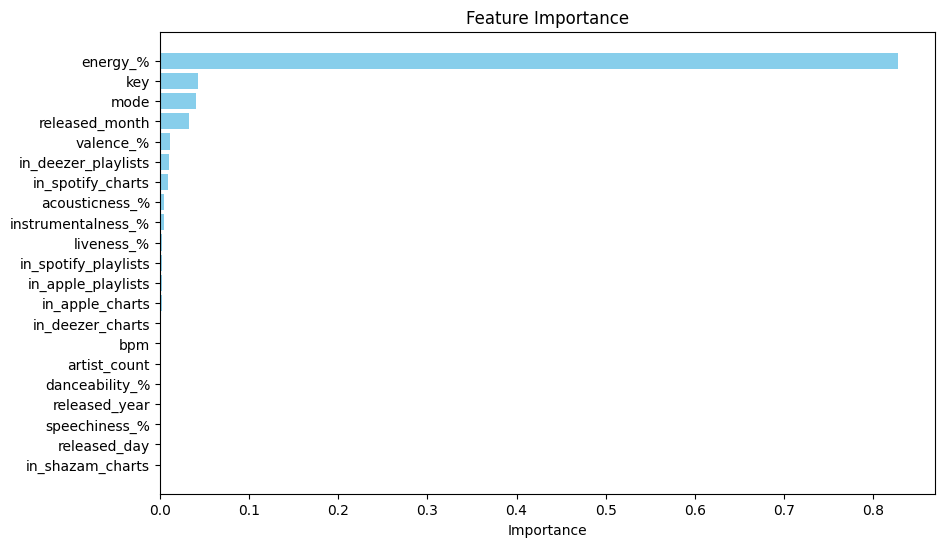

In [ ]:
importance = pipeline.named_steps['Regressor'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

1. **energy_%**: Главный признак, определяющий количество прослушиваний — уровень энергии трека.
2. **key, mode**: Музыкальные характеристики (тональность и лад) также значимы.
3. **released_month**: Сезонный фактор влияет на популярность треков.
4. **valence_%**: Эмоциональный тон трека имеет умеренное значение.
5. **Плейлисты/чарты**: Признаки in_deezer_playlists, in_spotify_charts и т.д. имеют низкую важность.
6. **Акустические характеристики**: acousticness_% и instrumentalness_% малозначимы.
7. **Менее значимые признаки**: bpm, artist_count, released_year и др. практически не влияют на модель.

Модель опирается в основном на энергетику, музыкальные характеристики и сезонность.


## Shap

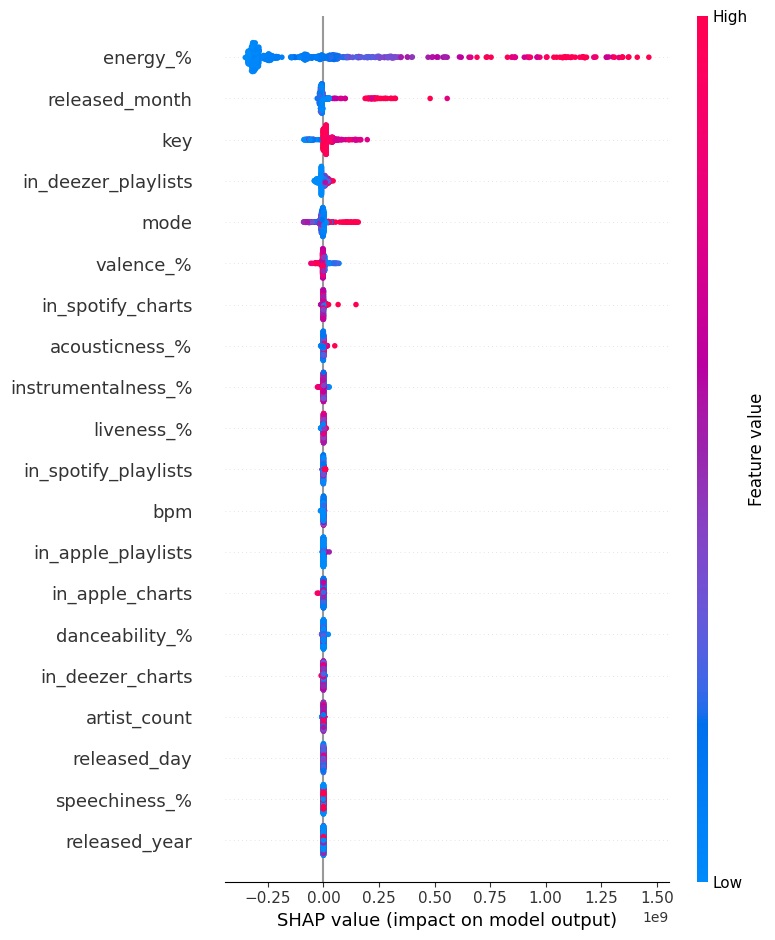

In [ ]:
preprocessed_X = pd.DataFrame(pipeline.named_steps['Preprocessor'].transform(train_X), columns=train_X.columns)
explainer = shap.TreeExplainer(pipeline.named_steps['Regressor'])
shap_values = explainer.shap_values(preprocessed_X)
shap.summary_plot(shap_values, preprocessed_X)

1. **energy_%**: Самый значимый признак. Высокие значения сильно повышают количество прослушиваний.
2. **released_month**: Сезонность влияет на популярность (например, новые релизы в определённые месяцы).
3. **key, mode**: Тональность и лад умеренно влияют на предсказания.
4. **in_deezer_playlists**: Признаки плейлистов также значимы, но меньше энергетики и месяца релиза.
5. **valence_%**: Эмоциональный тон оказывает небольшой положительный эффект.
6. **Признаки с низким влиянием**: liveness_%, acousticness_%, bpm, speechiness_% и др.

SHAP-значения показывают, что основные факторы — энергетика и сезонность, с меньшим вкладом музыкальных характеристик и наличия в плейлистах.

## Вывод


Результат предсказуем, так как:
- **energy_%** доминирует как на графике важности признаков, так и на SHAP-графике, что соответствует ожиданиям — энергичные треки более популярны;
- **released_month** подтверждает влияние сезонности, что логично для музыкальной индустрии (хиты выпускаются в стратегические месяцы);
- **Музыкальные характеристики (key, mode, valence_%)** оказывают влияние, но второстепенное, что согласуется с тем, что популярность больше зависит от настроения трека и времени релиза, чем от тональных особенностей;
- **Признаки плейлистов/чартов (in_deezer_playlists, in_spotify_charts)** ожидаемо играют роль, но с меньшим весом, так как популярность скорее влияет на включение в плейлисты, а не наоборот.

Модель подчеркивает очевидные связи: энергия, сезонность и эмоциональный тон — ключевые факторы популярности треков.